## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop

## Accessing Data

In [2]:
df_2021 = pd.read_csv('dataset/indeks-standar-pencemaran-udara-(ispu)-jakarta-2021.csv')

In [3]:
df_2022 = pd.read_csv('dataset/indeks-standar-pencemaran-udara-(ispu)-jakarta-2022.csv')

In [4]:
df_2023 = pd.read_csv('dataset/indeks-standar-pencemaran-udara-(ispu)-jakarta-2023.csv')

## Data Preprocessing

In [5]:
to_num = ['pm_sepuluh', 'pm_duakomalima', 'sulfur_dioksida', 'karbon_monoksida', 'ozon', 'nitrogen_dioksida', 'max']

In [6]:
cols_to_interpolate = ['pm_sepuluh','pm_duakomalima','sulfur_dioksida','karbon_monoksida','ozon','nitrogen_dioksida']

### df_2021

In [7]:
df_2021 = df_2021.rename(columns={
    'pm10': 'pm_sepuluh',
    'pm25': 'pm_duakomalima',
    'so2': 'sulfur_dioksida',
    'co': 'karbon_monoksida',
    'o3': 'ozon',
    'no2': 'nitrogen_dioksida',
    'critical': 'parameter_pencemar_kritis',
    'categori': 'kategori'
})

In [8]:
df_2021.replace('---', None, inplace=True)

In [9]:
# df_2021['stasiun'] = df_2021['stasiun'].str.replace(r'\(|\)', '')

In [10]:
df_2021['stasiun'] = df_2021['stasiun'].apply(lambda x: x.replace('(', '').replace(')', ''))

In [11]:
df_2021['stasiun'] = df_2021['stasiun'].str.replace('Jakarta Barat', '')

In [12]:
df_2021['stasiun'] = df_2021['stasiun'].apply(lambda x: ' '.join(x.strip().split()))

In [13]:
df_2021[df_2021['kategori'] == 'TIDAK ADA DATA'].count()

periode_data                 16
tanggal                      16
stasiun                      16
pm_sepuluh                    0
pm_duakomalima                0
sulfur_dioksida               0
karbon_monoksida              0
ozon                          0
nitrogen_dioksida             0
max                          16
parameter_pencemar_kritis     0
kategori                     16
dtype: int64

In [14]:
df_2021.drop(df_2021[df_2021['kategori'] == 'TIDAK ADA DATA'].index, inplace=True)

In [15]:
df_2021.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1809 entries, 0 to 1824
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   periode_data               1809 non-null   int64 
 1   tanggal                    1809 non-null   object
 2   stasiun                    1809 non-null   object
 3   pm_sepuluh                 1757 non-null   object
 4   pm_duakomalima             1725 non-null   object
 5   sulfur_dioksida            1710 non-null   object
 6   karbon_monoksida           1789 non-null   object
 7   ozon                       1757 non-null   object
 8   nitrogen_dioksida          1790 non-null   object
 9   max                        1809 non-null   int64 
 10  parameter_pencemar_kritis  1809 non-null   object
 11  kategori                   1809 non-null   object
dtypes: int64(2), object(10)
memory usage: 183.7+ KB


In [16]:
df_2021.head()

,periode_data,tanggal,stasiun,pm_sepuluh,pm_duakomalima,sulfur_dioksida,karbon_monoksida,ozon,nitrogen_dioksida,max,parameter_pencemar_kritis,kategori
0,202112,2021-12-19,DKI3 Jagakarsa,57,90,34,20,48,23,90,PM25,SEDANG
1,202112,2021-12-20,DKI3 Jagakarsa,54,74,34,13,43,15,74,PM25,SEDANG
2,202112,2021-12-21,DKI3 Jagakarsa,49,72,34,14,39,18,72,PM25,SEDANG
3,202112,2021-12-22,DKI3 Jagakarsa,56,82,34,21,44,24,82,PM25,SEDANG
4,202112,2021-12-23,DKI3 Jagakarsa,56,78,34,12,44,17,78,PM25,SEDANG


In [17]:
df_2021[to_num] = df_2021[to_num].apply(pd.to_numeric, errors='coerce')

In [18]:
df_2021['tanggal'] = pd.to_datetime(df_2021['tanggal'])

In [19]:
df_2021.isna().sum()

periode_data                  0
tanggal                       0
stasiun                       0
pm_sepuluh                   52
pm_duakomalima               84
sulfur_dioksida              99
karbon_monoksida             20
ozon                         52
nitrogen_dioksida            19
max                           0
parameter_pencemar_kritis     0
kategori                      0
dtype: int64

#### DKI 1 Bunderan HI

In [20]:
df_dki1_2021 = df_2021[df_2021['stasiun'] == 'DKI1 Bunderan HI']

df_dki1_2021 = df_dki1_2021.sort_values(by='tanggal')

In [21]:
df_dki1_2021.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 1771 to 133
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   periode_data               365 non-null    int64         
 1   tanggal                    365 non-null    datetime64[ns]
 2   stasiun                    365 non-null    object        
 3   pm_sepuluh                 365 non-null    float64       
 4   pm_duakomalima             365 non-null    float64       
 5   sulfur_dioksida            364 non-null    float64       
 6   karbon_monoksida           365 non-null    float64       
 7   ozon                       365 non-null    float64       
 8   nitrogen_dioksida          365 non-null    float64       
 9   max                        365 non-null    int64         
 10  parameter_pencemar_kritis  365 non-null    object        
 11  kategori                   365 non-null    object        
dtypes: datetim

In [22]:
df_dki1_2021.isna().sum()

periode_data                 0
tanggal                      0
stasiun                      0
pm_sepuluh                   0
pm_duakomalima               0
sulfur_dioksida              1
karbon_monoksida             0
ozon                         0
nitrogen_dioksida            0
max                          0
parameter_pencemar_kritis    0
kategori                     0
dtype: int64

In [23]:
df_dki1_2021 = df_dki1_2021.set_index('tanggal')

In [24]:
df_dki1_2021[cols_to_interpolate] = df_dki1_2021[cols_to_interpolate].interpolate(method='time').round()

In [25]:
df_dki1_2021.isna().sum()

periode_data                 0
stasiun                      0
pm_sepuluh                   0
pm_duakomalima               0
sulfur_dioksida              0
karbon_monoksida             0
ozon                         0
nitrogen_dioksida            0
max                          0
parameter_pencemar_kritis    0
kategori                     0
dtype: int64

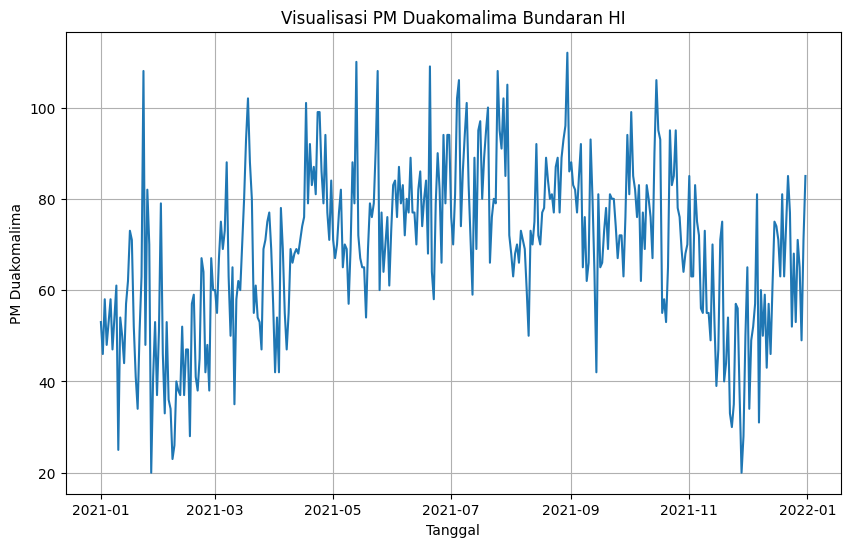

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(df_dki1_2021.index,df_dki1_2021['pm_duakomalima'], linestyle='-')
plt.title('Visualisasi PM Duakomalima Bundaran HI')
plt.xlabel('Tanggal')
plt.ylabel('PM Duakomalima')
plt.grid(True)
plt.show()

#### DKI 2 Kelapa Gading

In [27]:
df_dki2_2021 = df_2021[df_2021['stasiun'] == 'DKI2 Kelapa Gading']

df_dki2_2021 = df_dki2_2021.sort_values(by='tanggal')

In [28]:
df_dki2_2021.info()

<class 'pandas.core.frame.DataFrame'>
Index: 362 entries, 1802 to 99
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   periode_data               362 non-null    int64         
 1   tanggal                    362 non-null    datetime64[ns]
 2   stasiun                    362 non-null    object        
 3   pm_sepuluh                 357 non-null    float64       
 4   pm_duakomalima             349 non-null    float64       
 5   sulfur_dioksida            346 non-null    float64       
 6   karbon_monoksida           356 non-null    float64       
 7   ozon                       360 non-null    float64       
 8   nitrogen_dioksida          358 non-null    float64       
 9   max                        362 non-null    int64         
 10  parameter_pencemar_kritis  362 non-null    object        
 11  kategori                   362 non-null    object        
dtypes: datetime

In [29]:
df_dki2_2021.isna().sum()

periode_data                  0
tanggal                       0
stasiun                       0
pm_sepuluh                    5
pm_duakomalima               13
sulfur_dioksida              16
karbon_monoksida              6
ozon                          2
nitrogen_dioksida             4
max                           0
parameter_pencemar_kritis     0
kategori                      0
dtype: int64

In [30]:
df_dki2_2021 = df_dki2_2021.set_index('tanggal')

In [31]:
df_dki2_2021[cols_to_interpolate] = df_dki2_2021[cols_to_interpolate].interpolate(method='time').round()

In [32]:
df_dki2_2021.isna().sum()

periode_data                 0
stasiun                      0
pm_sepuluh                   0
pm_duakomalima               0
sulfur_dioksida              0
karbon_monoksida             0
ozon                         0
nitrogen_dioksida            0
max                          0
parameter_pencemar_kritis    0
kategori                     0
dtype: int64

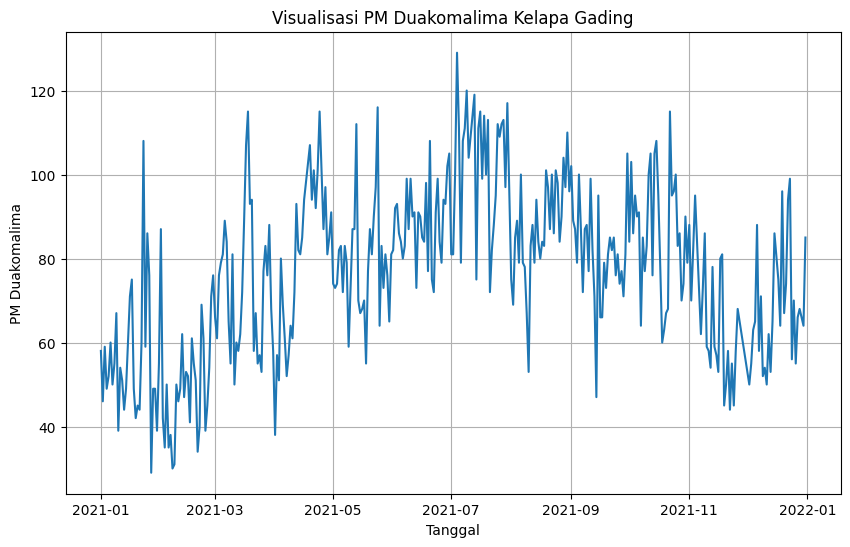

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(df_dki2_2021.index,df_dki2_2021['pm_duakomalima'], linestyle='-')
plt.title('Visualisasi PM Duakomalima Kelapa Gading')
plt.xlabel('Tanggal')
plt.ylabel('PM Duakomalima')
plt.grid(True)
plt.show()

#### DKI 3 Jagakarsa

In [34]:
df_dki3_2021 = df_2021[df_2021['stasiun'] == 'DKI3 Jagakarsa']

df_dki3_2021 = df_dki3_2021.sort_values(by='tanggal')

In [35]:
df_dki3_2021.info()

<class 'pandas.core.frame.DataFrame'>
Index: 363 entries, 1705 to 12
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   periode_data               363 non-null    int64         
 1   tanggal                    363 non-null    datetime64[ns]
 2   stasiun                    363 non-null    object        
 3   pm_sepuluh                 349 non-null    float64       
 4   pm_duakomalima             358 non-null    float64       
 5   sulfur_dioksida            359 non-null    float64       
 6   karbon_monoksida           363 non-null    float64       
 7   ozon                       327 non-null    float64       
 8   nitrogen_dioksida          360 non-null    float64       
 9   max                        363 non-null    int64         
 10  parameter_pencemar_kritis  363 non-null    object        
 11  kategori                   363 non-null    object        
dtypes: datetime

In [36]:
df_dki3_2021.isna().sum()

periode_data                  0
tanggal                       0
stasiun                       0
pm_sepuluh                   14
pm_duakomalima                5
sulfur_dioksida               4
karbon_monoksida              0
ozon                         36
nitrogen_dioksida             3
max                           0
parameter_pencemar_kritis     0
kategori                      0
dtype: int64

In [37]:
df_dki3_2021 = df_dki3_2021.set_index('tanggal')

In [38]:
df_dki3_2021[cols_to_interpolate] = df_dki3_2021[cols_to_interpolate].interpolate(method='time').round()

In [39]:
df_dki3_2021.isna().sum()

periode_data                 0
stasiun                      0
pm_sepuluh                   0
pm_duakomalima               0
sulfur_dioksida              0
karbon_monoksida             0
ozon                         0
nitrogen_dioksida            0
max                          0
parameter_pencemar_kritis    0
kategori                     0
dtype: int64

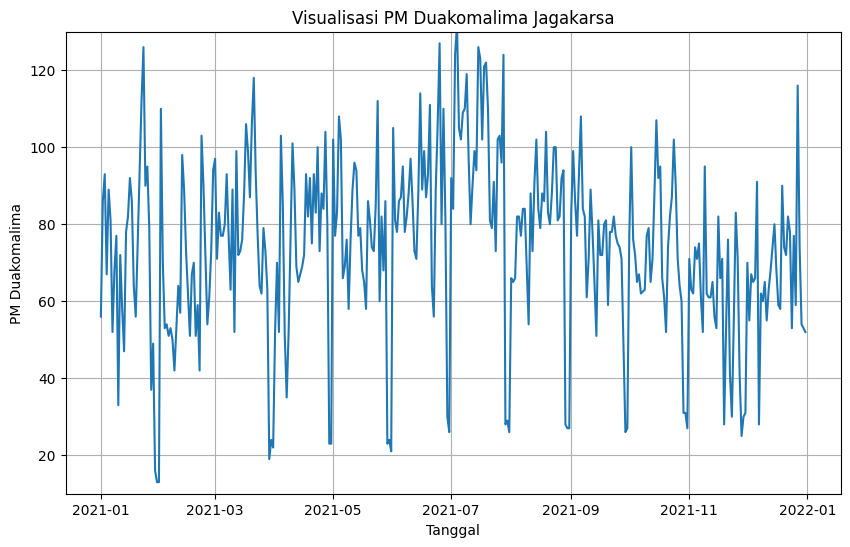

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(df_dki3_2021.index,df_dki3_2021['pm_duakomalima'], linestyle='-')
plt.title('Visualisasi PM Duakomalima Jagakarsa')
plt.xlabel('Tanggal')
plt.ylabel('PM Duakomalima')
plt.grid(True)
plt.ylim(10, 130)
plt.show()

#### DKI 4 Lubang Buaya

In [41]:
df_dki4_2021 = df_2021[df_2021['stasiun'] == 'DKI4 Lubang Buaya']

df_dki4_2021 = df_dki4_2021.sort_values(by='tanggal')

In [42]:
df_dki4_2021.info()

<class 'pandas.core.frame.DataFrame'>
Index: 355 entries, 1736 to 44
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   periode_data               355 non-null    int64         
 1   tanggal                    355 non-null    datetime64[ns]
 2   stasiun                    355 non-null    object        
 3   pm_sepuluh                 333 non-null    float64       
 4   pm_duakomalima             323 non-null    float64       
 5   sulfur_dioksida            351 non-null    float64       
 6   karbon_monoksida           341 non-null    float64       
 7   ozon                       341 non-null    float64       
 8   nitrogen_dioksida          351 non-null    float64       
 9   max                        355 non-null    int64         
 10  parameter_pencemar_kritis  355 non-null    object        
 11  kategori                   355 non-null    object        
dtypes: datetime

In [43]:
df_dki4_2021.isna().sum()

periode_data                  0
tanggal                       0
stasiun                       0
pm_sepuluh                   22
pm_duakomalima               32
sulfur_dioksida               4
karbon_monoksida             14
ozon                         14
nitrogen_dioksida             4
max                           0
parameter_pencemar_kritis     0
kategori                      0
dtype: int64

In [44]:
df_dki4_2021 = df_dki4_2021.set_index('tanggal')

In [45]:
df_dki4_2021[cols_to_interpolate] = df_dki4_2021[cols_to_interpolate].interpolate(method='time').round()

In [46]:
df_dki4_2021.isna().sum()

periode_data                  0
stasiun                       0
pm_sepuluh                    0
pm_duakomalima               29
sulfur_dioksida               0
karbon_monoksida              0
ozon                          0
nitrogen_dioksida             0
max                           0
parameter_pencemar_kritis     0
kategori                      0
dtype: int64

In [47]:
# Reset Indeks untuk proses merge 
df_dki1_2021.reset_index(drop=False, inplace=True)
df_dki2_2021.reset_index(drop=False, inplace=True)
df_dki3_2021.reset_index(drop=False, inplace=True)
df_dki4_2021.reset_index(drop=False, inplace=True)

# Menggabungkan DataFrames dengan metode 'merge'
df_dki4_2021 = df_dki4_2021.merge(df_dki1_2021[['tanggal', 'pm_duakomalima']], on='tanggal', how='left', suffixes=('', '_dki1'))
df_dki4_2021 = df_dki4_2021.merge(df_dki2_2021[['tanggal', 'pm_duakomalima']], on='tanggal', how='left', suffixes=('', '_dki2'))
df_dki4_2021 = df_dki4_2021.merge(df_dki3_2021[['tanggal', 'pm_duakomalima']], on='tanggal', how='left', suffixes=('', '_dki3'))

# Menghitung rata-rata untuk setiap tanggal
df_dki4_2021['pm_duakomalima_avg'] = df_dki4_2021[['pm_duakomalima_dki1', 'pm_duakomalima_dki2', 'pm_duakomalima_dki3']].mean(axis=1).round()

# Mengisi nilai yang hilang pada 'pm_duakomalima' di df_dki4_2021 dengan rata-rata
df_dki4_2021['pm_duakomalima'].fillna(df_dki4_2021['pm_duakomalima_avg'], inplace=True)

# Menghapus kolom-kolom tambahan yang digunakan untuk perhitungan rata-rata
df_dki4_2021.drop(columns=['pm_duakomalima_dki1', 'pm_duakomalima_dki2', 'pm_duakomalima_dki3', 'pm_duakomalima_avg'], inplace=True)

C:\Users\wilda\AppData\Local\Temp\ipykernel_28480\285379465.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_dki4_2021['pm_duakomalima'].fillna(df_dki4_2021['pm_duakomalima_avg'], inplace=True)


In [48]:
df_dki4_2021.isna().sum()

tanggal                      0
periode_data                 0
stasiun                      0
pm_sepuluh                   0
pm_duakomalima               0
sulfur_dioksida              0
karbon_monoksida             0
ozon                         0
nitrogen_dioksida            0
max                          0
parameter_pencemar_kritis    0
kategori                     0
dtype: int64

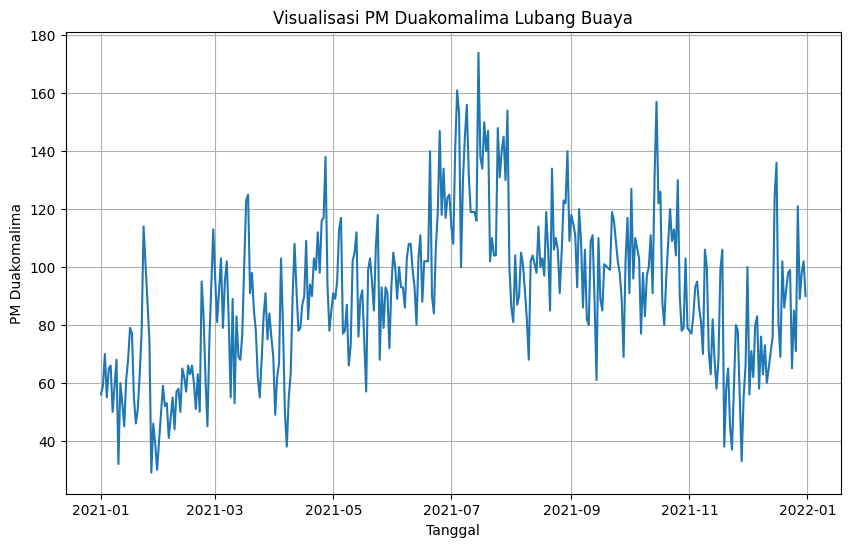

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(df_dki4_2021['tanggal'], df_dki4_2021['pm_duakomalima'], linestyle='-')
plt.title('Visualisasi PM Duakomalima Lubang Buaya')
plt.xlabel('Tanggal')
plt.ylabel('PM Duakomalima')
plt.grid(True)
plt.show()

In [50]:
# Q1 = (df_dki4['pm_duakomalima']).quantile(0.25)
# Q3 = (df_dki4['pm_duakomalima']).quantile(0.75)
# IQR = Q3 - Q1

# maximum = Q3 + (1.5*IQR)
# minimum = Q1 - (1.5*IQR)

# kondisi_lower_than = df_dki4['pm_duakomalima'] < minimum
# kondisi_more_than = df_dki4['pm_duakomalima'] > maximum

# df_dki4['pm_duakomalima'] = df_dki4['pm_duakomalima'].mask(kondisi_more_than, maximum)
# df_dki4['pm_duakomalima'] = df_dki4['pm_duakomalima'].mask(kondisi_lower_than, minimum)

#### DKI 5 Kebon Jeruk

In [51]:
df_dki5_2021 = df_2021[df_2021['stasiun'] == 'DKI5 Kebon Jeruk']

df_dki5_2021 = df_dki5_2021.sort_values(by='tanggal')

In [52]:
df_dki5_2021.info()

<class 'pandas.core.frame.DataFrame'>
Index: 364 entries, 1676 to 75
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   periode_data               364 non-null    int64         
 1   tanggal                    364 non-null    datetime64[ns]
 2   stasiun                    364 non-null    object        
 3   pm_sepuluh                 353 non-null    float64       
 4   pm_duakomalima             330 non-null    float64       
 5   sulfur_dioksida            290 non-null    float64       
 6   karbon_monoksida           364 non-null    float64       
 7   ozon                       364 non-null    float64       
 8   nitrogen_dioksida          356 non-null    float64       
 9   max                        364 non-null    int64         
 10  parameter_pencemar_kritis  364 non-null    object        
 11  kategori                   364 non-null    object        
dtypes: datetime

In [53]:
df_dki5_2021.isna().sum()

periode_data                  0
tanggal                       0
stasiun                       0
pm_sepuluh                   11
pm_duakomalima               34
sulfur_dioksida              74
karbon_monoksida              0
ozon                          0
nitrogen_dioksida             8
max                           0
parameter_pencemar_kritis     0
kategori                      0
dtype: int64

In [54]:
df_dki5_2021 = df_dki5_2021.set_index('tanggal')

In [55]:
df_dki5_2021[cols_to_interpolate] = df_dki5_2021[cols_to_interpolate].interpolate(method='time').round()

In [56]:
df_dki5_2021.isna().sum()

periode_data                  0
stasiun                       0
pm_sepuluh                    0
pm_duakomalima               31
sulfur_dioksida               0
karbon_monoksida              0
ozon                          0
nitrogen_dioksida             0
max                           0
parameter_pencemar_kritis     0
kategori                      0
dtype: int64

In [57]:
df_dki5_2021.reset_index(drop=False, inplace=True)

In [58]:
# Menggabungkan DataFrames dengan metode 'merge'
df_dki5_2021 = df_dki5_2021.merge(df_dki1_2021[['tanggal', 'pm_duakomalima']], on='tanggal', how='left', suffixes=('', '_dki1'))
df_dki5_2021 = df_dki5_2021.merge(df_dki2_2021[['tanggal', 'pm_duakomalima']], on='tanggal', how='left', suffixes=('', '_dki2'))
df_dki5_2021 = df_dki5_2021.merge(df_dki3_2021[['tanggal', 'pm_duakomalima']], on='tanggal', how='left', suffixes=('', '_dki3'))
df_dki5_2021 = df_dki5_2021.merge(df_dki4_2021[['tanggal', 'pm_duakomalima']], on='tanggal', how='left', suffixes=('', '_dki4'))

# Menghitung rata-rata untuk setiap tanggal
df_dki5_2021['pm_duakomalima_avg'] = df_dki5_2021[['pm_duakomalima_dki1', 'pm_duakomalima_dki2', 'pm_duakomalima_dki3', 'pm_duakomalima_dki4']].mean(axis=1).round()

# Mengisi nilai yang hilang pada 'pm_duakomalima' di df_dki5_2021 dengan rata-rata
df_dki5_2021['pm_duakomalima'].fillna(df_dki5_2021['pm_duakomalima_avg'], inplace=True)

# Menghapus kolom-kolom tambahan yang digunakan untuk perhitungan rata-rata
df_dki5_2021.drop(columns=['pm_duakomalima_dki1', 'pm_duakomalima_dki2', 'pm_duakomalima_dki3', 'pm_duakomalima_dki4', 'pm_duakomalima_avg'], inplace=True)

C:\Users\wilda\AppData\Local\Temp\ipykernel_28480\3221044165.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_dki5_2021['pm_duakomalima'].fillna(df_dki5_2021['pm_duakomalima_avg'], inplace=True)


In [59]:
df_dki5_2021.isna().sum()

tanggal                      0
periode_data                 0
stasiun                      0
pm_sepuluh                   0
pm_duakomalima               0
sulfur_dioksida              0
karbon_monoksida             0
ozon                         0
nitrogen_dioksida            0
max                          0
parameter_pencemar_kritis    0
kategori                     0
dtype: int64

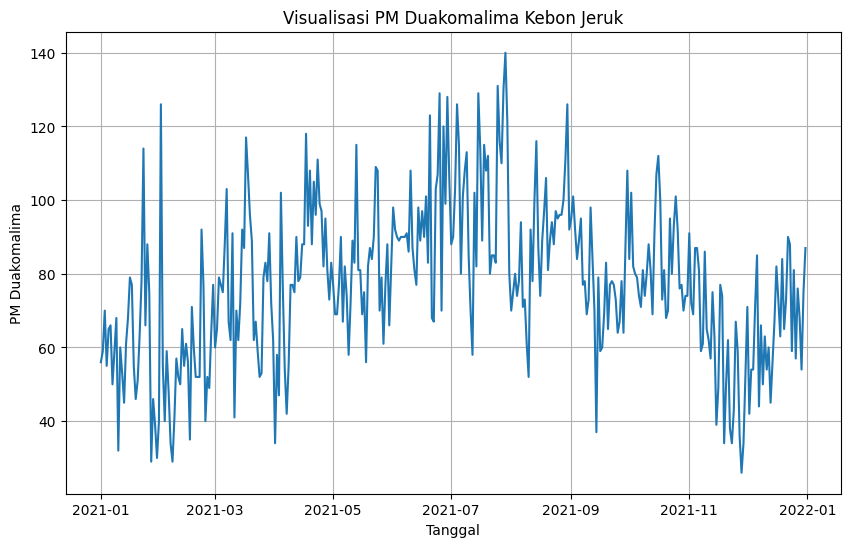

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(df_dki5_2021['tanggal'], df_dki5_2021['pm_duakomalima'], linestyle='-')
plt.title('Visualisasi PM Duakomalima Kebon Jeruk')
plt.xlabel('Tanggal')
plt.ylabel('PM Duakomalima')
plt.grid(True)
plt.show()


In [61]:
cleaned_2021 = pd.concat([df_dki1_2021, df_dki2_2021, df_dki3_2021, df_dki4_2021, df_dki5_2021])

In [62]:
cleaned_2021.set_index('tanggal')

,periode_data,stasiun,pm_sepuluh,pm_duakomalima,sulfur_dioksida,karbon_monoksida,ozon,nitrogen_dioksida,max,parameter_pencemar_kritis,kategori
tanggal,,,,,,,,,,,
2021-01-01,202101,DKI1 Bunderan HI,38.0,53.0,29.0,6.0,31.0,13.0,53,PM25,SEDANG
2021-01-02,202101,DKI1 Bunderan HI,27.0,46.0,27.0,7.0,47.0,7.0,47,O3,BAIK
2021-01-03,202101,DKI1 Bunderan HI,44.0,58.0,25.0,7.0,40.0,13.0,58,PM25,SEDANG
2021-01-04,202101,DKI1 Bunderan HI,30.0,48.0,24.0,4.0,32.0,7.0,48,PM25,BAIK
2021-01-05,202101,DKI1 Bunderan HI,38.0,53.0,24.0,6.0,31.0,9.0,53,PM25,SEDANG
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,202112,DKI5 Kebon Jeruk,54.0,76.0,36.0,14.0,21.0,47.0,76,PM25,SEDANG
2021-12-28,202112,DKI5 Kebon Jeruk,44.0,68.0,20.0,11.0,21.0,33.0,68,PM25,SEDANG
2021-12-29,202112,DKI5 Kebon Jeruk,34.0,54.0,28.0,8.0,25.0,29.0,54,PM25,SEDANG


In [63]:
# Memperbarui kolom 'parameter_pencemar_kritis' berdasarkan nilai max
def update_parameter_pencemar(row):
    if row['max'] == row['pm_duakomalima']:
        return 'PM25'
    elif row['max'] == row['pm_sepuluh']:
        return 'PM10'
    elif row['max'] == row['sulfur_dioksida']:
        return 'SO2'
    elif row['max'] == row['karbon_monoksida']:
        return 'CO'
    elif row['max'] == row['ozon']:
        return 'O3'
    elif row['max'] == row['nitrogen_dioksida']:
        return 'NO2'
    # Jika tidak ada kondisi yang cocok, kembalikan nilai parameter_pencemar_kritis yang ada
    return row['parameter_pencemar_kritis']

cleaned_2021['parameter_pencemar_kritis'] = cleaned_2021.apply(update_parameter_pencemar, axis=1)

In [64]:
# Memperbarui kolom 'parameter_pencemar_kritis' berdasarkan nilai max
def update_kategori(row):
    if row['max'] >= 1 and row['max'] <= 50:
        return 'BAIK'
    elif row['max'] >= 51 and row['max'] <= 100:
        return 'SEDANG'
    elif row['max'] >= 101 and row['max'] <= 200:
        return 'TIDAK SEHAT'
    elif row['max'] >= 201 and row['max'] <= 300:
        return 'SANGAT TIDAK SEHAT'
    elif row['max'] >= 301:
        return 'BERBAHAYA'
    # Jika tidak ada kondisi yang cocok, kembalikan nilai parameter_pencemar_kritis yang ada
    return row['parameter_pencemar_kritis']

cleaned_2021['kategori'] = cleaned_2021.apply(update_kategori, axis=1)

In [65]:
cleaned_2021.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1809 entries, 0 to 363
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   tanggal                    1809 non-null   datetime64[ns]
 1   periode_data               1809 non-null   int64         
 2   stasiun                    1809 non-null   object        
 3   pm_sepuluh                 1809 non-null   float64       
 4   pm_duakomalima             1809 non-null   float64       
 5   sulfur_dioksida            1809 non-null   float64       
 6   karbon_monoksida           1809 non-null   float64       
 7   ozon                       1809 non-null   float64       
 8   nitrogen_dioksida          1809 non-null   float64       
 9   max                        1809 non-null   int64         
 10  parameter_pencemar_kritis  1809 non-null   object        
 11  kategori                   1809 non-null   object        
dtypes: datetime6

### df_2022

In [66]:
df_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   periode_data    365 non-null    int64 
 1   tanggal         365 non-null    object
 2   pm_10           365 non-null    int64 
 3   pm_duakomalima  365 non-null    int64 
 4   so2             365 non-null    int64 
 5   co              365 non-null    int64 
 6   o3              365 non-null    int64 
 7   no2             365 non-null    int64 
 8   max             365 non-null    int64 
 9   critical        365 non-null    object
 10  categori        365 non-null    object
 11  lokasi_spku     365 non-null    object
dtypes: int64(8), object(4)
memory usage: 34.3+ KB


In [67]:
df_2022 = df_2022.rename(columns={
    'pm_10': 'pm_sepuluh',
    'pm_duakomalima': 'pm_duakomalima',
    'so2': 'sulfur_dioksida',
    'co': 'karbon_monoksida',
    'o3': 'ozon',
    'no2': 'nitrogen_dioksida',
    'critical': 'parameter_pencemar_kritis',
    'categori': 'kategori',
    'lokasi_spku': 'stasiun'
})

In [68]:
df_2022 = df_2022[['tanggal','periode_data','stasiun','pm_sepuluh','pm_duakomalima','sulfur_dioksida','karbon_monoksida','ozon','nitrogen_dioksida','max','parameter_pencemar_kritis','kategori']]

In [69]:
df_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   tanggal                    365 non-null    object
 1   periode_data               365 non-null    int64 
 2   stasiun                    365 non-null    object
 3   pm_sepuluh                 365 non-null    int64 
 4   pm_duakomalima             365 non-null    int64 
 5   sulfur_dioksida            365 non-null    int64 
 6   karbon_monoksida           365 non-null    int64 
 7   ozon                       365 non-null    int64 
 8   nitrogen_dioksida          365 non-null    int64 
 9   max                        365 non-null    int64 
 10  parameter_pencemar_kritis  365 non-null    object
 11  kategori                   365 non-null    object
dtypes: int64(8), object(4)
memory usage: 34.3+ KB


In [70]:
df_2022['stasiun'] = df_2022['stasiun'].replace('DKI1', 'DKI1 Bunderan HI')
df_2022['stasiun'] = df_2022['stasiun'].replace('DKI2', 'DKI2 Kelapa Gading')
df_2022['stasiun'] = df_2022['stasiun'].replace('DKI3', 'DKI3 Jagakarsa')
df_2022['stasiun'] = df_2022['stasiun'].replace('DKI4', 'DKI4 Lubang Buaya')
df_2022['stasiun'] = df_2022['stasiun'].replace('DKI5', 'DKI5 Kebon Jeruk')

In [71]:
df_2022.replace("PM2,5", "PM25", inplace=True)

In [72]:
df_2022['tanggal'] = pd.to_datetime(df_2022['tanggal'])

In [73]:
cleaned_2022 = df_2022.sort_values(by='tanggal')

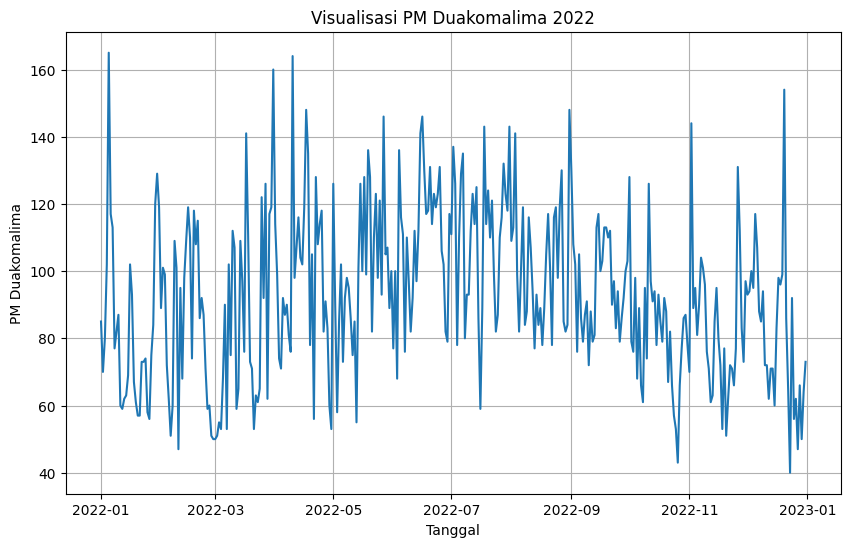

In [74]:
plt.figure(figsize=(10, 6))
plt.plot(cleaned_2022['tanggal'], cleaned_2022['pm_duakomalima'], linestyle='-')
plt.title('Visualisasi PM Duakomalima 2022')
plt.xlabel('Tanggal')
plt.ylabel('PM Duakomalima')
plt.grid(True)
plt.show()

### df_2023

In [75]:
df_2023['tanggal'] = pd.to_datetime(df_2023['tanggal'])

In [76]:
df_2023 = df_2023.sort_values(by='tanggal')

In [77]:
df_2023.replace('-', None, inplace=True)

In [78]:
df_2023.replace(' ', None, inplace=True)

In [79]:
df_2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1825 entries, 192 to 1824
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   periode_data               1825 non-null   int64         
 1   tanggal                    1825 non-null   datetime64[ns]
 2   stasiun                    1825 non-null   object        
 3   pm_sepuluh                 1603 non-null   object        
 4   pm_duakomalima             1530 non-null   object        
 5   sulfur_dioksida            1786 non-null   object        
 6   karbon_monoksida           1782 non-null   object        
 7   ozon                       1797 non-null   object        
 8   nitrogen_dioksida          1759 non-null   object        
 9   max                        1822 non-null   object        
 10  parameter_pencemar_kritis  1804 non-null   object        
 11  kategori                   1825 non-null   object        
dtypes: dateti

In [80]:
df_2023[to_num] = df_2023[to_num].apply(pd.to_numeric, errors='coerce')

In [81]:
df_2023.isna().sum()

periode_data                   0
tanggal                        0
stasiun                        0
pm_sepuluh                   222
pm_duakomalima               295
sulfur_dioksida               39
karbon_monoksida              44
ozon                          29
nitrogen_dioksida             66
max                            3
parameter_pencemar_kritis     21
kategori                       0
dtype: int64

In [82]:
df_2023['stasiun'] = df_2023['stasiun'].apply(lambda x: ' '.join(x.strip().split()))

In [83]:
df_2023.drop(df_2023[df_2023['kategori'] == 'TIDAK ADA DATA'].index, inplace=True)

In [84]:
df_2023['parameter_pencemar_kritis'] = df_2023['parameter_pencemar_kritis'].replace({'1': 'PM10', '2': 'PM25', '3': 'SO2', '4': 'CO', '5': 'O3', '6':'NO2'})

#### DKI 1 Bunderan HI

In [85]:
df_dki1_2023 = df_2023[df_2023['stasiun'] == 'DKI1 Bunderan HI']

In [86]:
df_dki1_2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 361 entries, 192 to 1658
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   periode_data               361 non-null    int64         
 1   tanggal                    361 non-null    datetime64[ns]
 2   stasiun                    361 non-null    object        
 3   pm_sepuluh                 361 non-null    float64       
 4   pm_duakomalima             361 non-null    float64       
 5   sulfur_dioksida            357 non-null    float64       
 6   karbon_monoksida           352 non-null    float64       
 7   ozon                       361 non-null    float64       
 8   nitrogen_dioksida          361 non-null    float64       
 9   max                        361 non-null    float64       
 10  parameter_pencemar_kritis  361 non-null    object        
 11  kategori                   361 non-null    object        
dtypes: datetim

In [87]:
df_dki1_2023 = df_dki1_2023.set_index('tanggal')

In [88]:
df_dki1_2023[cols_to_interpolate] = df_dki1_2023[cols_to_interpolate].interpolate(method='time').round()

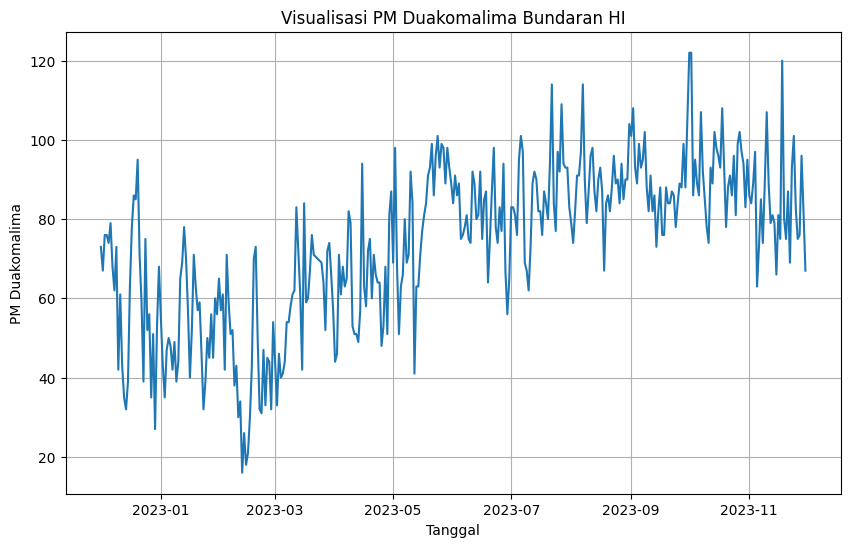

In [89]:
plt.figure(figsize=(10, 6))
plt.plot(df_dki1_2023.index,df_dki1_2023['pm_duakomalima'], linestyle='-')
plt.title('Visualisasi PM Duakomalima Bundaran HI')
plt.xlabel('Tanggal')
plt.ylabel('PM Duakomalima')
plt.grid(True)
plt.show()

#### DKI 2 Kelapa Gading

In [90]:
df_dki2_2023 = df_2023[df_2023['stasiun'] == 'DKI2 Kelapa Gading']

In [91]:
df_dki2_2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 363 entries, 223 to 1688
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   periode_data               363 non-null    int64         
 1   tanggal                    363 non-null    datetime64[ns]
 2   stasiun                    363 non-null    object        
 3   pm_sepuluh                 354 non-null    float64       
 4   pm_duakomalima             363 non-null    float64       
 5   sulfur_dioksida            357 non-null    float64       
 6   karbon_monoksida           362 non-null    float64       
 7   ozon                       362 non-null    float64       
 8   nitrogen_dioksida          361 non-null    float64       
 9   max                        363 non-null    float64       
 10  parameter_pencemar_kritis  363 non-null    object        
 11  kategori                   363 non-null    object        
dtypes: datetim

In [92]:
df_dki2_2023.isna().sum()

periode_data                 0
tanggal                      0
stasiun                      0
pm_sepuluh                   9
pm_duakomalima               0
sulfur_dioksida              6
karbon_monoksida             1
ozon                         1
nitrogen_dioksida            2
max                          0
parameter_pencemar_kritis    0
kategori                     0
dtype: int64

In [93]:
df_dki2_2023 = df_dki2_2023.set_index('tanggal')

In [94]:
df_dki2_2023[cols_to_interpolate] = df_dki2_2023[cols_to_interpolate].interpolate(method='time').round()

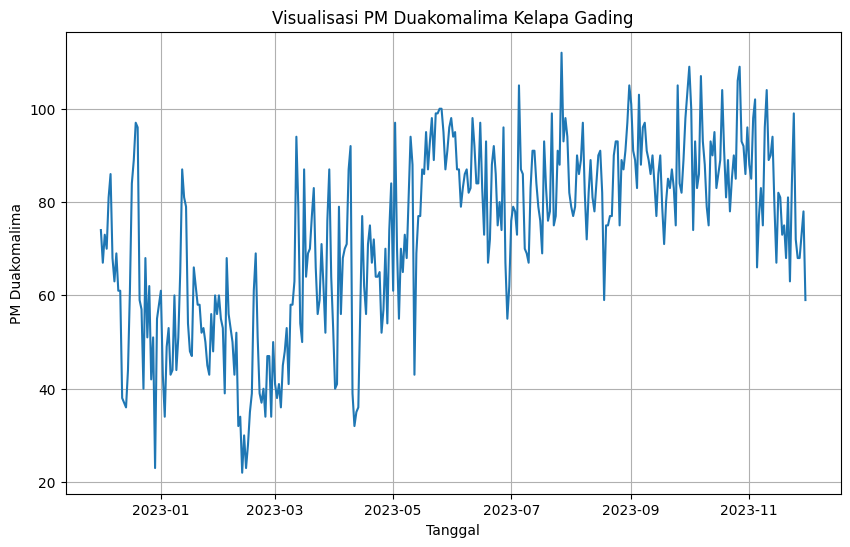

In [95]:
plt.figure(figsize=(10, 6))
plt.plot(df_dki2_2023.index,df_dki2_2023['pm_duakomalima'], linestyle='-')
plt.title('Visualisasi PM Duakomalima Kelapa Gading')
plt.xlabel('Tanggal')
plt.ylabel('PM Duakomalima')
plt.grid(True)
plt.show()

#### DKI 3 Jagakarsa

In [96]:
df_dki3_2023 = df_2023[df_2023['stasiun'] == 'DKI3 Jagakarsa']

In [97]:
df_dki3_2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 361 entries, 254 to 1718
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   periode_data               361 non-null    int64         
 1   tanggal                    361 non-null    datetime64[ns]
 2   stasiun                    361 non-null    object        
 3   pm_sepuluh                 354 non-null    float64       
 4   pm_duakomalima             352 non-null    float64       
 5   sulfur_dioksida            360 non-null    float64       
 6   karbon_monoksida           359 non-null    float64       
 7   ozon                       360 non-null    float64       
 8   nitrogen_dioksida          349 non-null    float64       
 9   max                        361 non-null    float64       
 10  parameter_pencemar_kritis  361 non-null    object        
 11  kategori                   361 non-null    object        
dtypes: datetim

In [98]:
df_dki3_2023.isna().sum()

periode_data                  0
tanggal                       0
stasiun                       0
pm_sepuluh                    7
pm_duakomalima                9
sulfur_dioksida               1
karbon_monoksida              2
ozon                          1
nitrogen_dioksida            12
max                           0
parameter_pencemar_kritis     0
kategori                      0
dtype: int64

In [99]:
df_dki3_2023 = df_dki3_2023.set_index('tanggal')

In [100]:
df_dki3_2023[cols_to_interpolate] = df_dki3_2023[cols_to_interpolate].interpolate(method='time').round()

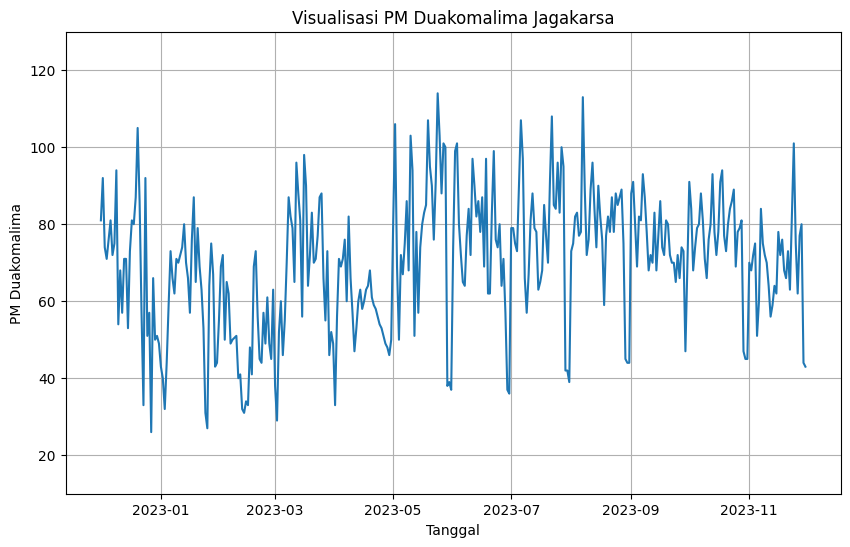

In [101]:
plt.figure(figsize=(10, 6))
plt.plot(df_dki3_2023.index,df_dki3_2023['pm_duakomalima'], linestyle='-')
plt.title('Visualisasi PM Duakomalima Jagakarsa')
plt.xlabel('Tanggal')
plt.ylabel('PM Duakomalima')
plt.grid(True)
plt.ylim(10, 130)
plt.show()

#### DKI 4 Lubang Buaya

In [102]:
df_dki4_2023 = df_2023[df_2023['stasiun'] == 'DKI4 Lubang Buaya']

In [103]:
df_dki4_2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 361 entries, 285 to 1794
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   periode_data               361 non-null    int64         
 1   tanggal                    361 non-null    datetime64[ns]
 2   stasiun                    361 non-null    object        
 3   pm_sepuluh                 185 non-null    float64       
 4   pm_duakomalima             357 non-null    float64       
 5   sulfur_dioksida            355 non-null    float64       
 6   karbon_monoksida           353 non-null    float64       
 7   ozon                       356 non-null    float64       
 8   nitrogen_dioksida          358 non-null    float64       
 9   max                        361 non-null    float64       
 10  parameter_pencemar_kritis  361 non-null    object        
 11  kategori                   361 non-null    object        
dtypes: datetim

In [104]:
df_dki4_2023.isna().sum()

periode_data                   0
tanggal                        0
stasiun                        0
pm_sepuluh                   176
pm_duakomalima                 4
sulfur_dioksida                6
karbon_monoksida               8
ozon                           5
nitrogen_dioksida              3
max                            0
parameter_pencemar_kritis      0
kategori                       0
dtype: int64

In [105]:
df_dki4_2023 = df_dki4_2023.set_index('tanggal')

In [106]:
df_dki4_2023[cols_to_interpolate] = df_dki4_2023[cols_to_interpolate].interpolate(method='time').round()

In [107]:
# Q1 = (df_dki4_2023['pm_duakomalima']).quantile(0.25)
# Q3 = (df_dki4_2023['pm_duakomalima']).quantile(0.75)
# IQR = Q3 - Q1

# maximum = Q3 + (1.5*IQR)
# minimum = Q1 - (1.5*IQR)

# kondisi_lower_than = df_dki4_2023['pm_duakomalima'] < minimum
# kondisi_more_than = df_dki4_2023['pm_duakomalima'] > maximum
# print(maximum)
# print(minimum)

# # median_value = df_dki4_2023['pm_duakomalima'].median()
# # print(median_value)

# df_dki4_2023['pm_duakomalima'] = df_dki4_2023['pm_duakomalima'].mask(kondisi_lower_than, minimum)
# df_dki4_2023['pm_duakomalima'] = df_dki4_2023['pm_duakomalima'].mask(kondisi_more_than, maximum)

In [108]:
df_dki4_2023.isna().sum()

periode_data                 0
stasiun                      0
pm_sepuluh                   0
pm_duakomalima               0
sulfur_dioksida              0
karbon_monoksida             0
ozon                         0
nitrogen_dioksida            0
max                          0
parameter_pencemar_kritis    0
kategori                     0
dtype: int64

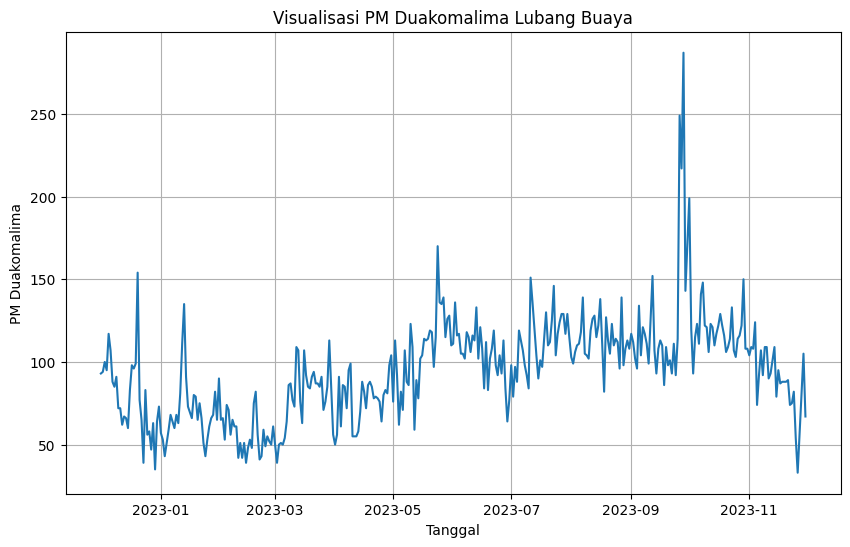

In [109]:
plt.figure(figsize=(10, 6))
plt.plot(df_dki4_2023.index,df_dki4_2023['pm_duakomalima'], linestyle='-')
plt.title('Visualisasi PM Duakomalima Lubang Buaya')
plt.xlabel('Tanggal')
plt.ylabel('PM Duakomalima')
plt.grid(True)
plt.show()

#### DKI 5 Kebon Jeruk

In [110]:
def remove_jakarta_barat(text):
    return text.replace(' Jakarta Barat', '')

# Terapkan fungsi pada kolom 'stasiun'
df_2023['stasiun'] = df_2023['stasiun'].apply(remove_jakarta_barat)

In [111]:
df_dki5_2023 = df_2023[df_2023['stasiun'] == 'DKI5 Kebon Jeruk']

In [112]:
df_dki5_2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 358 entries, 316 to 1824
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   periode_data               358 non-null    int64         
 1   tanggal                    358 non-null    datetime64[ns]
 2   stasiun                    358 non-null    object        
 3   pm_sepuluh                 349 non-null    float64       
 4   pm_duakomalima             97 non-null     float64       
 5   sulfur_dioksida            357 non-null    float64       
 6   karbon_monoksida           355 non-null    float64       
 7   ozon                       357 non-null    float64       
 8   nitrogen_dioksida          330 non-null    float64       
 9   max                        358 non-null    float64       
 10  parameter_pencemar_kritis  358 non-null    object        
 11  kategori                   358 non-null    object        
dtypes: datetim

In [113]:
df_dki5_2023.isna().sum()

periode_data                   0
tanggal                        0
stasiun                        0
pm_sepuluh                     9
pm_duakomalima               261
sulfur_dioksida                1
karbon_monoksida               3
ozon                           1
nitrogen_dioksida             28
max                            0
parameter_pencemar_kritis      0
kategori                       0
dtype: int64

In [114]:
df_dki1_2023.reset_index(drop=False, inplace=True)
df_dki2_2023.reset_index(drop=False, inplace=True)
df_dki3_2023.reset_index(drop=False, inplace=True)
df_dki4_2023.reset_index(drop=False, inplace=True)

In [115]:
# Menggabungkan DataFrames dengan metode 'merge'
df_dki5_2023 = df_dki5_2023.merge(df_dki1_2023[['tanggal', 'pm_duakomalima']], on='tanggal', how='left', suffixes=('', '_dki1'))
df_dki5_2023 = df_dki5_2023.merge(df_dki2_2023[['tanggal', 'pm_duakomalima']], on='tanggal', how='left', suffixes=('', '_dki2'))
df_dki5_2023 = df_dki5_2023.merge(df_dki3_2023[['tanggal', 'pm_duakomalima']], on='tanggal', how='left', suffixes=('', '_dki3'))
df_dki5_2023 = df_dki5_2023.merge(df_dki4_2023[['tanggal', 'pm_duakomalima']], on='tanggal', how='left', suffixes=('', '_dki4'))

# Menghitung rata-rata untuk setiap tanggal
df_dki5_2023['pm_duakomalima_avg'] = df_dki5_2023[['pm_duakomalima_dki1', 'pm_duakomalima_dki2', 'pm_duakomalima_dki3', 'pm_duakomalima_dki4']].mean(axis=1).round()

# Mengisi nilai yang hilang pada 'pm_duakomalima' di df_dki5_2023 dengan rata-rata
df_dki5_2023['pm_duakomalima'].fillna(df_dki5_2023['pm_duakomalima_avg'], inplace=True)

# Menghapus kolom-kolom tambahan yang digunakan untuk perhitungan rata-rata
df_dki5_2023.drop(columns=['pm_duakomalima_dki1', 'pm_duakomalima_dki2', 'pm_duakomalima_dki3', 'pm_duakomalima_dki4', 'pm_duakomalima_avg'], inplace=True)

C:\Users\wilda\AppData\Local\Temp\ipykernel_28480\349533165.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_dki5_2023['pm_duakomalima'].fillna(df_dki5_2023['pm_duakomalima_avg'], inplace=True)


In [116]:
df_dki5_2023.isna().sum()

periode_data                  0
tanggal                       0
stasiun                       0
pm_sepuluh                    9
pm_duakomalima                0
sulfur_dioksida               1
karbon_monoksida              3
ozon                          1
nitrogen_dioksida            28
max                           0
parameter_pencemar_kritis     0
kategori                      0
dtype: int64

In [117]:
df_dki5_2023 = df_dki5_2023.set_index('tanggal')

In [118]:
df_dki5_2023[cols_to_interpolate] = df_dki5_2023[cols_to_interpolate].interpolate(method='time').round()

In [119]:
max_values = df_dki5_2023[cols_to_interpolate].max(axis=1)

# Memeriksa dan mengganti nilai 'max' yang tidak sesuai
df_dki5_2023['max'] = df_dki5_2023.apply(lambda row: max(row['max'], max_values[row.name]), axis=1)

In [120]:
# Memperbarui kolom 'parameter_pencemar_kritis' berdasarkan nilai max
def update_parameter_pencemar(row):
    if row['max'] == row['pm_duakomalima']:
        return 'PM25'
    elif row['max'] == row['pm_sepuluh']:
        return 'PM10'
    elif row['max'] == row['sulfur_dioksida']:
        return 'SO2'
    elif row['max'] == row['karbon_monoksida']:
        return 'CO'
    elif row['max'] == row['ozon']:
        return 'O3'
    elif row['max'] == row['nitrogen_dioksida']:
        return 'NO2'
    # Jika tidak ada kondisi yang cocok, kembalikan nilai parameter_pencemar_kritis yang ada
    return row['parameter_pencemar_kritis']

df_dki5_2023['parameter_pencemar_kritis'] = df_dki5_2023.apply(update_parameter_pencemar, axis=1)

In [121]:
# Memperbarui kolom 'parameter_pencemar_kritis' berdasarkan nilai max
def update_kategori(row):
    if row['max'] >= 1 and row['max'] <= 50:
        return 'BAIK'
    elif row['max'] >= 51 and row['max'] <= 100:
        return 'SEDANG'
    elif row['max'] >= 101 and row['max'] <= 200:
        return 'TIDAK SEHAT'
    elif row['max'] >= 201 and row['max'] <= 300:
        return 'SANGAT TIDAK SEHAT'
    elif row['max'] >= 301:
        return 'BERBAHAYA'
    # Jika tidak ada kondisi yang cocok, kembalikan nilai parameter_pencemar_kritis yang ada
    return row['parameter_pencemar_kritis']

df_dki5_2023['kategori'] = df_dki5_2023.apply(update_kategori, axis=1)

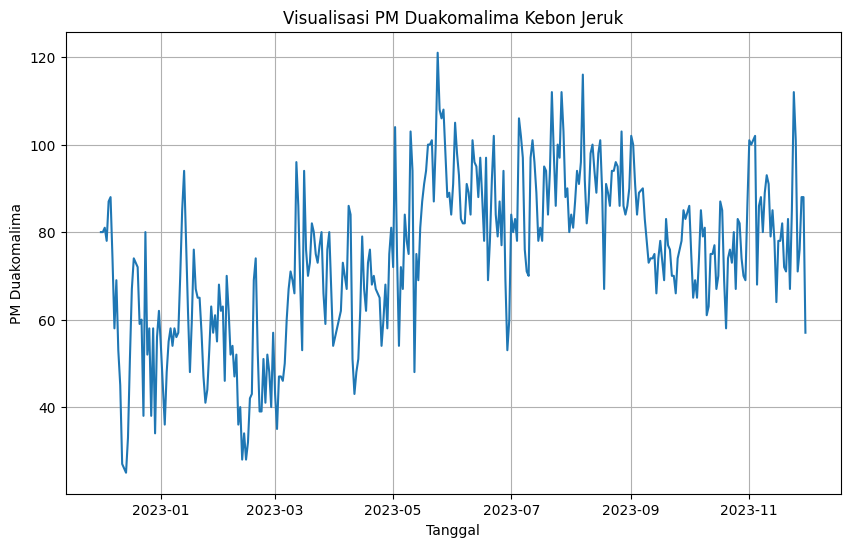

In [122]:
plt.figure(figsize=(10, 6))
plt.plot(df_dki5_2023.index, df_dki5_2023['pm_duakomalima'], linestyle='-')
plt.title('Visualisasi PM Duakomalima Kebon Jeruk')
plt.xlabel('Tanggal')
plt.ylabel('PM Duakomalima')
plt.grid(True)
plt.show()


In [123]:
df_dki5_2023.reset_index(drop=False, inplace=True)

In [124]:
cleaned_2023 = pd.concat([df_dki1_2023, df_dki2_2023, df_dki3_2023, df_dki4_2023, df_dki5_2023])

In [125]:
cleaned_2023 = cleaned_2023[cleaned_2023['tanggal'].dt.year == 2023]

In [126]:
cleaned_2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1649 entries, 31 to 357
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   tanggal                    1649 non-null   datetime64[ns]
 1   periode_data               1649 non-null   int64         
 2   stasiun                    1649 non-null   object        
 3   pm_sepuluh                 1649 non-null   float64       
 4   pm_duakomalima             1649 non-null   float64       
 5   sulfur_dioksida            1649 non-null   float64       
 6   karbon_monoksida           1649 non-null   float64       
 7   ozon                       1649 non-null   float64       
 8   nitrogen_dioksida          1649 non-null   float64       
 9   max                        1649 non-null   float64       
 10  parameter_pencemar_kritis  1649 non-null   object        
 11  kategori                   1649 non-null   object        
dtypes: datetime

### Merging DataFrame

In [127]:
merged_df = pd.concat([cleaned_2021, cleaned_2022, cleaned_2023], ignore_index=True)

In [128]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3823 entries, 0 to 3822
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   tanggal                    3823 non-null   datetime64[ns]
 1   periode_data               3823 non-null   int64         
 2   stasiun                    3823 non-null   object        
 3   pm_sepuluh                 3823 non-null   float64       
 4   pm_duakomalima             3823 non-null   float64       
 5   sulfur_dioksida            3823 non-null   float64       
 6   karbon_monoksida           3823 non-null   float64       
 7   ozon                       3823 non-null   float64       
 8   nitrogen_dioksida          3823 non-null   float64       
 9   max                        3823 non-null   float64       
 10  parameter_pencemar_kritis  3823 non-null   object        
 11  kategori                   3823 non-null   object        
dtypes: dat

In [129]:
merged_df = merged_df.sort_values(by=['tanggal', 'stasiun'])

In [130]:
merged_df.sample(10)

,tanggal,periode_data,stasiun,pm_sepuluh,pm_duakomalima,sulfur_dioksida,karbon_monoksida,ozon,nitrogen_dioksida,max,parameter_pencemar_kritis,kategori
1544,2021-04-11,202104,DKI5 Kebon Jeruk,46.0,75.0,50.0,9.0,31.0,18.0,75.0,PM25,SEDANG
346,2021-12-13,202112,DKI1 Bunderan HI,31.0,46.0,34.0,10.0,13.0,6.0,46.0,PM25,BAIK
3667,2023-06-25,202306,DKI5 Kebon Jeruk,49.0,87.0,19.0,14.0,77.0,14.0,87.0,PM25,SEDANG
1471,2021-01-27,202101,DKI5 Kebon Jeruk,15.0,29.0,16.0,5.0,20.0,14.0,20.0,O3,BAIK
3025,2023-07-12,202307,DKI3 Jagakarsa,67.0,88.0,53.0,9.0,27.0,14.0,88.0,PM25,SEDANG
579,2021-08-05,202108,DKI2 Kelapa Gading,61.0,79.0,55.0,9.0,58.0,18.0,79.0,PM25,SEDANG
2892,2023-02-28,202302,DKI3 Jagakarsa,46.0,63.0,14.0,7.0,17.0,4.0,63.0,PM25,SEDANG
314,2021-11-11,202111,DKI1 Bunderan HI,41.0,55.0,48.0,12.0,13.0,15.0,55.0,PM25,SEDANG
2252,2023-03-20,202303,DKI1 Bunderan HI,54.0,76.0,47.0,13.0,28.0,33.0,76.0,PM25,SEDANG
2636,2023-05-14,202305,DKI2 Kelapa Gading,53.0,77.0,51.0,10.0,29.0,26.0,77.0,PM25,SEDANG


In [131]:
df_ready = merged_df.loc[merged_df.groupby('tanggal')['pm_duakomalima'].idxmax()]

In [132]:
df_ready.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1063 entries, 365 to 2503
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   tanggal                    1063 non-null   datetime64[ns]
 1   periode_data               1063 non-null   int64         
 2   stasiun                    1063 non-null   object        
 3   pm_sepuluh                 1063 non-null   float64       
 4   pm_duakomalima             1063 non-null   float64       
 5   sulfur_dioksida            1063 non-null   float64       
 6   karbon_monoksida           1063 non-null   float64       
 7   ozon                       1063 non-null   float64       
 8   nitrogen_dioksida          1063 non-null   float64       
 9   max                        1063 non-null   float64       
 10  parameter_pencemar_kritis  1063 non-null   object        
 11  kategori                   1063 non-null   object        
dtypes: dateti

In [133]:
df_ready.describe()

,tanggal,periode_data,pm_sepuluh,pm_duakomalima,sulfur_dioksida,karbon_monoksida,ozon,nitrogen_dioksida,max
count,1063,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,2022-06-16 01:22:38.043273728,202203.353716,60.548448,94.279398,39.767639,16.250235,36.667921,21.125118,94.359360
min,2021-01-01 00:00:00,202101.000000,17.000000,37.000000,2.000000,3.000000,5.000000,1.000000,37.000000
25%,2021-09-23 12:00:00,202109.000000,52.000000,76.000000,32.000000,11.000000,22.000000,14.000000,76.000000
50%,2022-06-16 00:00:00,202206.000000,61.000000,93.000000,40.000000,15.000000,30.000000,20.000000,94.000000
75%,2023-03-08 12:00:00,202303.000000,71.000000,111.000000,49.000000,21.000000,48.000000,27.000000,111.000000
max,2023-11-30 00:00:00,202311.000000,163.000000,287.000000,67.000000,55.000000,181.000000,55.000000,287.000000
std,NaN,80.878830,15.756781,26.270074,10.604320,7.302544,22.332401,9.623337,26.349361


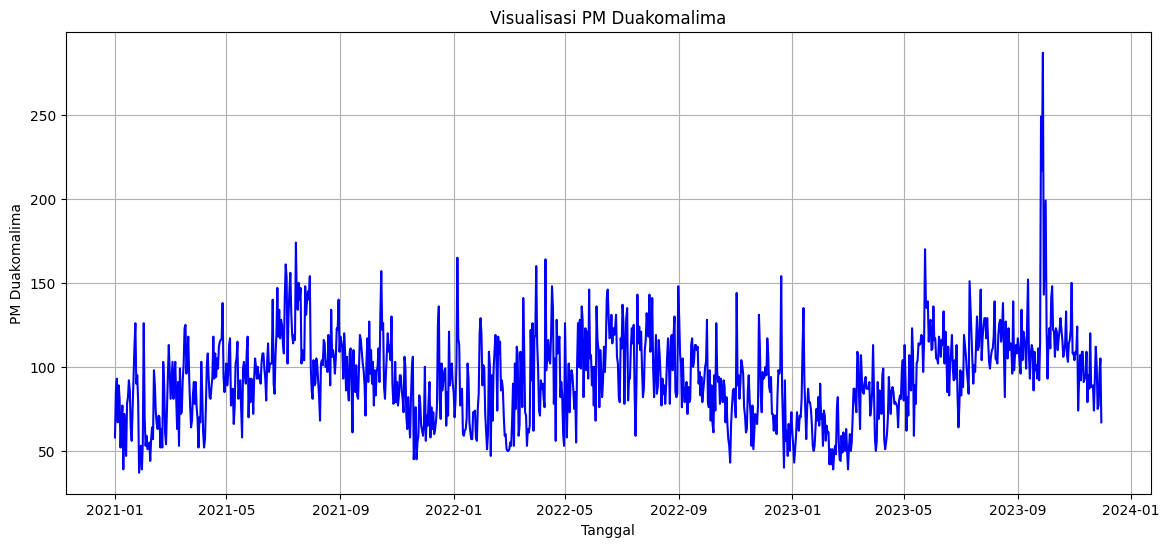

In [134]:
plt.figure(figsize=(14, 6))
plt.plot(df_ready['tanggal'], df_ready['pm_duakomalima'], linestyle='-', color='blue')
plt.title('Visualisasi PM Duakomalima')
plt.xlabel('Tanggal')
plt.ylabel('PM Duakomalima')
plt.grid()
plt.show()

## Pembuatan Model

In [135]:
df_predict = df_ready[['tanggal', 'pm_duakomalima']]
df_predict.set_index('tanggal', inplace=True)

In [136]:
df_predict.head()

,pm_duakomalima
tanggal,
2021-01-01,58.0
2021-01-02,86.0
2021-01-03,93.0
2021-01-04,67.0
2021-01-05,89.0


In [137]:
df_predict.describe()

,pm_duakomalima
count,1063.000000
mean,94.279398
std,26.270074
min,37.000000
25%,76.000000
50%,93.000000
75%,111.000000
max,287.000000


In [261]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_predict['pm_duakomalima'].values.reshape(-1,1))

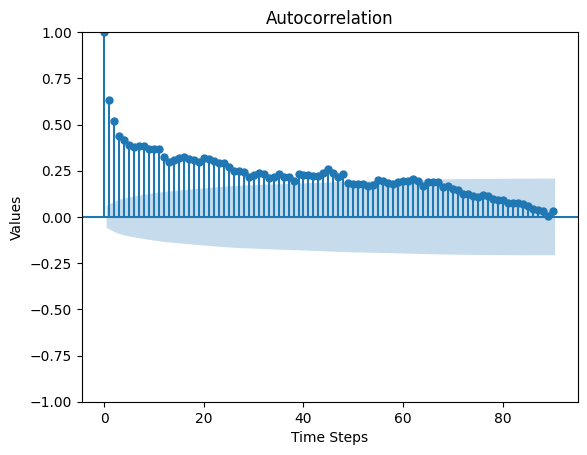

In [262]:
from statsmodels.graphics.tsaplots import plot_acf
acf_plot = plot_acf(scaled_data, lags=90)
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.show()


In [263]:
# Membagi data menjadi data training dan testing
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size:, :]

# Fungsi untuk membuat dataset
def create_dataset(dataset, time_steps):
    X, Y = [], []
    for i in range(len(dataset)-time_steps):
        a = dataset[i:(i+time_steps), 0]
        X.append(a)
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

time_steps = 10

X_train, Y_train = create_dataset(train_data, time_steps)
X_test, Y_test = create_dataset(test_data, time_steps)

# Reshape input menjadi [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [264]:
# print(devider)

In [265]:
optimizer = Adam(learning_rate=0.01)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Membuat model LSTM
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=150, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Melatih model
history = model.fit(X_train, Y_train, epochs=1000, batch_size=32, verbose=2, validation_data=[X_test, Y_test],callbacks=[early_stopping])

model.save('lstm_pm25_model.h5')

Epoch 1/1000
27/27 - 3s - 104ms/step - loss: 0.0106 - val_loss: 0.0124
Epoch 2/1000
27/27 - 0s - 6ms/step - loss: 0.0069 - val_loss: 0.0093
Epoch 3/1000
27/27 - 0s - 5ms/step - loss: 0.0063 - val_loss: 0.0086
Epoch 4/1000
27/27 - 0s - 5ms/step - loss: 0.0063 - val_loss: 0.0091
Epoch 5/1000
27/27 - 0s - 5ms/step - loss: 0.0069 - val_loss: 0.0081
Epoch 6/1000
27/27 - 0s - 5ms/step - loss: 0.0061 - val_loss: 0.0095
Epoch 7/1000
27/27 - 0s - 5ms/step - loss: 0.0063 - val_loss: 0.0120
Epoch 8/1000
27/27 - 0s - 5ms/step - loss: 0.0060 - val_loss: 0.0074
Epoch 9/1000
27/27 - 0s - 5ms/step - loss: 0.0062 - val_loss: 0.0086
Epoch 10/1000
27/27 - 0s - 5ms/step - loss: 0.0061 - val_loss: 0.0091
Epoch 11/1000
27/27 - 0s - 5ms/step - loss: 0.0060 - val_loss: 0.0083
Epoch 12/1000
27/27 - 0s - 5ms/step - loss: 0.0059 - val_loss: 0.0075
Epoch 13/1000
27/27 - 0s - 5ms/step - loss: 0.0060 - val_loss: 0.0074
Epoch 14/1000
27/27 - 0s - 6ms/step - loss: 0.0062 - val_loss: 0.0088
Epoch 15/1000
27/27 - 0s - 

In [266]:
# Prediksi dengan model yang telah dilatih
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


In [267]:
# Inverse transformasi prediksi
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

In [268]:
# Menghitung nilai RMSE (Root Mean Squared Error)
test_rmse = mean_absolute_percentage_error(Y_train[0], train_predict[:,0]) * 100
print("Test RMSE:", test_rmse)

Test RMSE: 18.16894915949764


In [269]:
# Menghitung nilai RMSE (Root Mean Squared Error)
test_rmse = root_mean_squared_error(Y_test[0], test_predict[:,0])
print("Test RMSE:", test_rmse)

Test RMSE: 21.483597842937666


In [270]:
test_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:,0]) * 100
print(f"Test MAPE: {test_mape:.2f}%")

Test MAPE: 12.15%


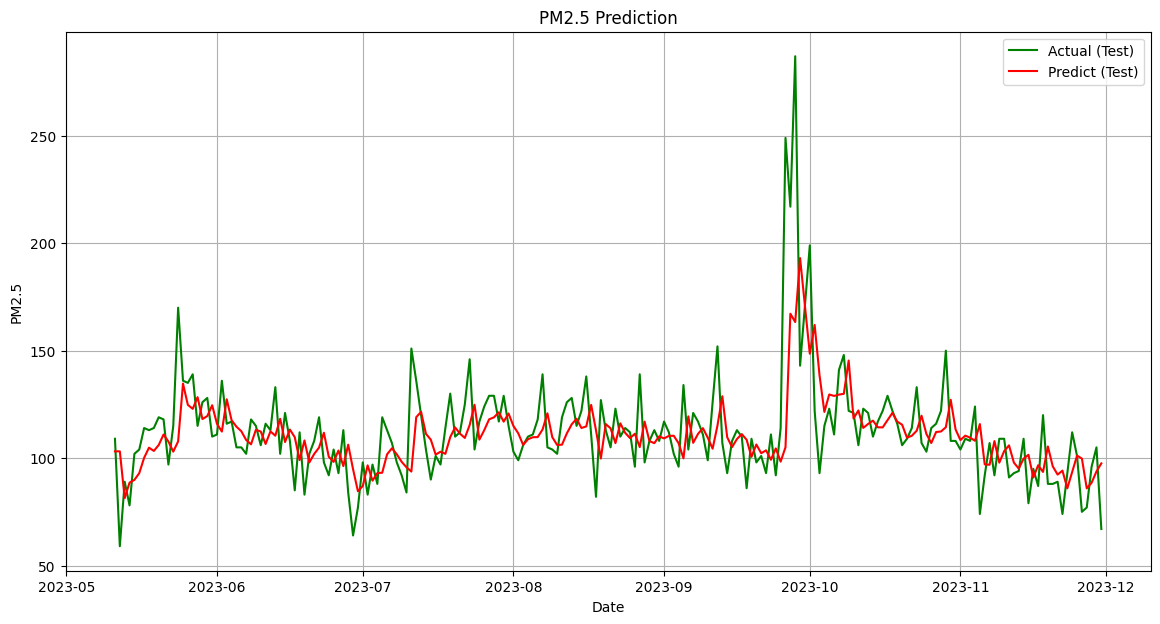

In [271]:
# Plot hasil prediksi
plt.figure(figsize=(14,7))
# plt.plot(df_predict.index[time_steps:time_steps+len(train_predict)], Y_train.reshape(-1), color='blue', label='Actual (Train)')
# plt.plot(df_predict.index[time_steps:time_steps+len(train_predict)], train_predict[:,0], color='red', label='Predicted (Train)')
plt.plot(df_predict.index[time_steps+time_steps+len(train_predict):time_steps+time_steps+len(train_predict)+len(test_predict)], Y_test.reshape(-1), color='green', label='Actual (Test)')
plt.plot(df_predict.index[time_steps+time_steps+len(train_predict):time_steps+time_steps+len(train_predict)+len(test_predict)], test_predict[:,0], color='red', label='Predict (Test)')
plt.title('PM2.5 Prediction')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.grid()
plt.legend()
plt.show()

In [272]:
devider

NameError: name 'devider' is not defined

In [277]:
from keras.models import load_model  

model = load_model('lstm_pm25_model.h5')

# Mengambil data terakhir dari set pengujian sebagai titik awal untuk prediksi masa depan
last_data = test_data[-time_steps:]

# Fungsi untuk menghitung jumlah hari antara dua tanggal
def calculate_days_to_predict(start_date, end_date):
    return (end_date - start_date).days

# Tanggal yang diinputkan oleh pengguna
input_date = pd.Timestamp('2024-01-01')
last_date = pd.Timestamp('2023-11-30')

# Menghitung jumlah hari untuk prediksi
num_days_to_predict = calculate_days_to_predict(last_date, input_date)

# Membuat array untuk menyimpan prediksi masa depan
future_predictions = []

for _ in range(num_days_to_predict):
    # Mengambil subset terakhir dari last_data dengan panjang time_steps
    input_data = last_data[-time_steps:].reshape(1, 1, time_steps)
    
    # Membuat prediksi
    prediction = model.predict(input_data)
    
    # Menyimpan prediksi
    future_predictions.append(prediction[0, 0])
    
    # Memperbarui last_data dengan menambahkan prediksi terbaru
    last_data = np.append(last_data, prediction)
    
# Inverse transformasi prediksi masa depan
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Membulatkan hasil prediksi
future_predictions = np.round(future_predictions)

# Membuat DataFrame untuk hasil prediksi masa depan
future_dates = pd.date_range(start=df_predict.index[-1], periods=num_days_to_predict + 1, inclusive='right')
future_df = pd.DataFrame(future_predictions, index=future_dates, columns=['Prediksi_PM25'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

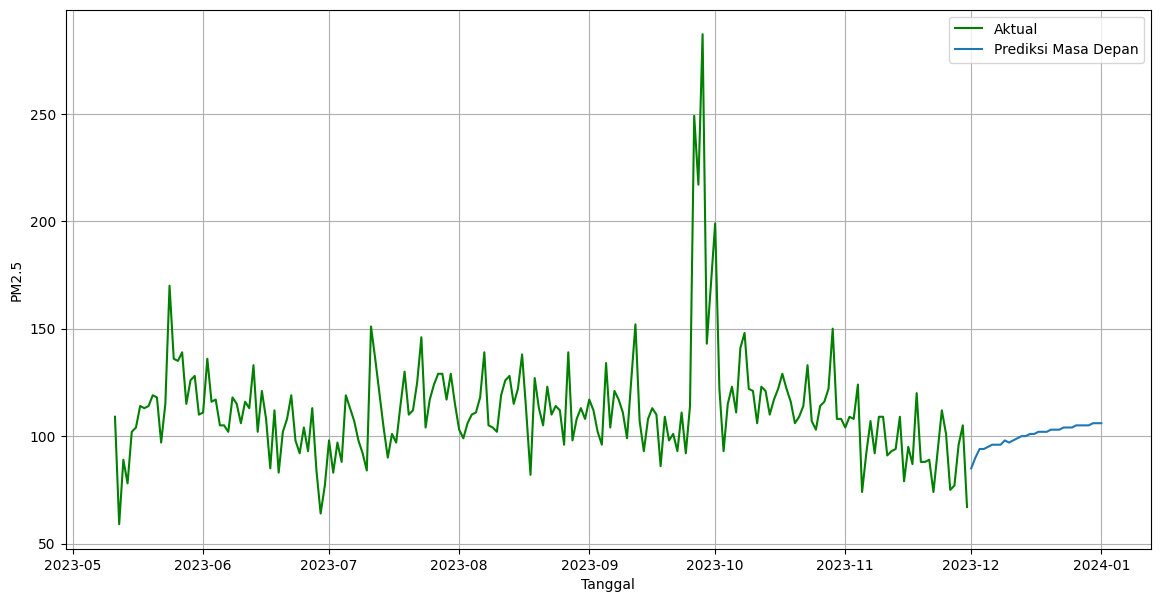

In [278]:
plt.figure(figsize=(14, 7))
plt.plot(df_predict.index[time_steps+time_steps+len(train_predict):time_steps+time_steps+len(train_predict)+len(test_predict)], Y_test.reshape(-1), color='green', label='Aktual')
plt.plot(future_df.index, future_df['Prediksi_PM25'], label='Prediksi Masa Depan')
plt.xlabel('Tanggal')
plt.ylabel('PM2.5')
plt.grid()
plt.legend()
plt.show()

In [281]:
future_df.to_csv('future.csv')

In [280]:
print(devider)

NameError: name 'devider' is not defined

In [ ]:
import keras_tuner as kt

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

def build_model(hp):
    model = Sequential()
    for i in range(hp.Choice('layers', [1, 2])):
        model.add(LSTM(units=hp.Choice('units', [50, 100, 150]), 
                       activation=hp.Choice('activation', ['tanh', 'relu', 'sigmoid']),
                       return_sequences=True if i < hp.Choice('layers', [1, 2]) - 1 else False))
        model.add(Dropout(0.2))  # Adding dropout layer with 0.2 rate
    model.add(Dense(1))
    
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Choice('learning_rate', [0.001, 0.01])
    
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

tuner = kt.GridSearch(
    build_model,
    objective='val_loss',
    max_trials=72,
    executions_per_trial=5,
    directory='my_dir',
    project_name='lstm_tuning'
)

tuner.search(X_train, Y_train, epochs=1000, batch_size=32, validation_data=(X_test, Y_test), callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
tuner.results_summary()

print(f"""
Best hyperparameters:
- Units: {best_hps.get('units')}
- Layers: {best_hps.get('layers')}
- Activation: {best_hps.get('activation')}
- Optimizer: {best_hps.get('optimizer')}
- Learning Rate: {best_hps.get('learning_rate')}
""")


Trial 72 Complete [00h 02m 14s]
val_loss: 0.008635327406227588

Best val_loss So Far: 0.007315538730472327
Total elapsed time: 01h 51m 37s
Results summary
Results in my_dir\lstm_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 25 summary
Hyperparameters:
layers: 1
units: 150
activation: tanh
optimizer: adam
learning_rate: 0.01
Score: 0.007315538730472327

Trial 01 summary
Hyperparameters:
layers: 1
units: 50
activation: tanh
optimizer: adam
learning_rate: 0.01
Score: 0.0073439997620880606

Trial 62 summary
Hyperparameters:
layers: 2
units: 150
activation: tanh
optimizer: rmsprop
learning_rate: 0.001
Score: 0.007347449101507664

Trial 50 summary
Hyperparameters:
layers: 2
units: 100
activation: tanh
optimizer: rmsprop
learning_rate: 0.001
Score: 0.007355919480323792

Trial 38 summary
Hyperparameters:
layers: 2
units: 50
activation: tanh
optimizer: rmsprop
learning_rate: 0.001
Score: 0.007357109989970923

Trial 13 summary
Hyperparameters:
layers: 1
units: 